# 4th Study Case: Recommender System

Restaurant and Consumer Recommender System<br>
*with Content-Based Filtering*

Naufal Mu'afi<br>
nmuafi1@gmail.com

---

In [1]:
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

## 1. Data Understanding
---

### Load the Data

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00232/RCdata.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# local_zip = './RCdata.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('./data')
# zip_ref.close()

### Read the Data

In [4]:
accepts = pd.read_csv('./data/chefmozaccepts.csv')
cuisine = pd.read_csv('./data/chefmozcuisine.csv')
hours = pd.read_csv('./data/chefmozhours4.csv')
parking = pd.read_csv('./data/chefmozparking.csv')
geo = pd.read_csv('./data/geoplaces2.csv', encoding = "ISO-8859-1")
usercuisine = pd.read_csv('./data/usercuisine.csv')
payment = pd.read_csv('./data/userpayment.csv')
profile = pd.read_csv('./data/userprofile.csv')
rating = pd.read_csv('./data/rating_final.csv')
 
print('The amount of payment data the restaurant accepts ', len(accepts.placeID.unique()))
print('Number of food data in restaurants: ', len(cuisine.placeID.unique()))
print('Number of restaurant opening times data: ', len(hours.placeID.unique()))
print('Number of restaurant location data: ', len(geo.placeID.unique()))
print('Number of user cuisine data: ', len(usercuisine.userID.unique()))
print('Number of user profile data: ', len(profile.userID.unique()))
print('Number of user-provided ratings data: ', len(rating.userID.unique()))
print('Number of restaurant rating data: ', len(rating.placeID.unique()))

The amount of payment data the restaurant accepts  615
Number of food data in restaurants:  769
Number of restaurant opening times data:  694
Number of restaurant location data:  130
Number of user cuisine data:  138
Number of user profile data:  138
Number of user-provided ratings data:  138
Number of restaurant rating data:  130


## 2. Univariate Exploratory Data Analysis (EDA)
---

In this project, we're just going to explore some of variables/features, namely: `accept`, `cuisine`, `profile`, `rating`.

The `accept` and `cuisine` variable categorized as restaurant data, and the `profile` and `rating` variable categorized as user data.

### 2.1. Accept Variable

In [5]:
accepts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   placeID   1314 non-null   int64 
 1   Rpayment  1314 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.7+ KB


In [6]:
print(f"Number of Data: {len(accepts.placeID.unique())}")
print(f"Number of Rpayment that accepts: {len(accepts.Rpayment.unique())}")
print(f"Type of Rpayment that accepts: {accepts.Rpayment.unique()}")

Number of Data: 615
Number of Rpayment that accepts: 12
Type of Rpayment that accepts: ['cash' 'VISA' 'MasterCard-Eurocard' 'American_Express' 'bank_debit_cards'
 'checks' 'Discover' 'Carte_Blanche' 'Diners_Club' 'Visa'
 'Japan_Credit_Bureau' 'gift_certificates']


### 2.2. Cuisine Variable

In [7]:
cuisine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   placeID   916 non-null    int64 
 1   Rcuisine  916 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.4+ KB


In [8]:
print(f"Number of Food Type: {len(cuisine.Rcuisine.unique())}")
print(f"Type of Food: {cuisine.Rcuisine.unique()}")

Number of Food Type: 59
Type of Food: ['Spanish' 'Italian' 'Latin_American' 'Mexican' 'Fast_Food' 'Burgers'
 'Dessert-Ice_Cream' 'Hot_Dogs' 'Steaks' 'Asian' 'International'
 'Mongolian' 'Vegetarian' 'Brazilian' 'Cafe-Coffee_Shop' 'Cafeteria'
 'Contemporary' 'Deli-Sandwiches' 'Diner' 'Japanese' 'Sushi' 'Seafood'
 'Chinese' 'Bar' 'Bar_Pub_Brewery' 'Pizzeria' 'Mediterranean' 'American'
 'Family' 'Caribbean' 'African' 'Breakfast-Brunch' 'Regional' 'Afghan'
 'Bakery' 'Game' 'Armenian' 'Vietnamese' 'Korean' 'Thai' 'Barbecue'
 'Polish' 'Dutch-Belgian' 'French' 'German' 'Southwestern' 'Persian'
 'Ethiopian' 'Juice' 'Soup' 'Continental-European' 'Greek' 'Southern'
 'Eastern_European' 'California' 'Bagels' 'Turkish' 'Organic-Healthy'
 'Fine_Dining']


### 2.3. Profile Variable

In [9]:
print(profile.shape)

(138, 19)


In [10]:
profile.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69


### 2.4. Rating Variable

In [11]:
rating.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [12]:
rating.describe()

,placeID,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000,1161.000000
mean,134192.041344,1.199828,1.215332,1.090439
std,1100.916275,0.773282,0.792294,0.790844
min,132560.000000,0.000000,0.000000,0.000000
25%,132856.000000,1.000000,1.000000,0.000000
50%,135030.000000,1.000000,1.000000,1.000000
75%,135059.000000,2.000000,2.000000,2.000000
max,135109.000000,2.000000,2.000000,2.000000


In [13]:
print(f"Number of UserID: {len(rating.userID.unique())}")
print(f"Number of PlaceID: {len(rating.placeID.unique())}")
print(f"Total amount of rating data: {len(rating)}")

Number of UserID: 138
Number of PlaceID: 130
Total amount of rating data: 1161


## 3. Data Preprocessing
---

### Concatenate All Restaurant

In [14]:
# concatenate all placeID in Restaurant category
resto_all = np.concatenate((
  accepts.placeID.unique(),  
  cuisine.placeID.unique(),  
  hours.placeID.unique(),  
  parking.placeID.unique(),  
  geo.placeID.unique(),  
))

# sort the data and remove the duplicate data
resto_all = np.sort(np.unique(resto_all))

print(f"Total amount of restaurant data by placeID: {len(resto_all)}")

Total amount of restaurant data by placeID: 938


### Concatenate All User

In [15]:
# concatenate all userID
user_all = np.concatenate((
  usercuisine.userID.unique(),  
  payment.userID.unique(),  
  profile.userID.unique(),    
))

# sort the data and remove the duplicate data
user_all = np.sort(np.unique(user_all))

print(f"Total amount of user data by userID: {len(user_all)}")

Total amount of user data by userID: 138


### The Numbers of Rating

In [16]:
# concatenate restaurant info
resto_info = pd.concat([accepts, geo, parking, hours])

# merge rating df with resto_info by placeID value
resto = pd.merge(rating, resto_info, on='placeID', how='left')
resto

,userID,placeID,rating,food_rating,service_rating,Rpayment,latitude,longitude,the_geom_meter,name,...,accessibility,price,url,Rambience,franchise,area,other_services,parking_lot,hours,days
0,U1077,135085,2,2,2,cash,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U1077,135085,2,2,2,NaN,22.150802,-100.982680,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,...,no_accessibility,medium,?,familiar,f,closed,none,NaN,NaN,NaN
2,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,public,NaN,NaN
3,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;
4,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-00:00;,Sat;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8073,U1068,132660,0,0,0,NaN,23.752943,-99.164679,0101000020957F00003D7905C9DC8157C13FCD1AB7334E...,carnitas mata calle Emilio Portes Gil,...,completely,low,?,familiar,f,closed,none,NaN,NaN,NaN
8074,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN
8075,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;
8076,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-23:30;,Sat;


The implication is the emergence of many missing values, which can be observed in:

In [17]:
resto.isnull().sum()

userID               0
placeID              0
rating               0
food_rating          0
service_rating       0
Rpayment          5781
latitude          6917
longitude         6917
the_geom_meter    6917
name              6917
address           6917
city              6917
state             6917
country           6917
fax               6917
zip               6917
alcohol           6917
smoking_area      6917
dress_code        6917
accessibility     6917
price             6917
url               6917
Rambience         6917
franchise         6917
area              6917
other_services    6917
parking_lot       6917
hours             4619
days              4619
dtype: int64

In [18]:
# calculate the number of rating, food_rating, and service then group by placeID
resto.groupby('placeID').sum()

,userID,rating,food_rating,service_rating,Rpayment,latitude,longitude,the_geom_meter,name,address,...,accessibility,price,url,Rambience,franchise,area,other_services,parking_lot,hours,days
placeID,,,,,,,,,,,,,,,,,,,,,
132560,U1067U1067U1067U1067U1067U1067U1082U1082U1082U...,12,24,6,cashcashcashcash,95.009216,-396.667653,0101000020957F0000FC60BDA8E88157C1B2C357D6DA4E...,puesto de gorditaspuesto de gorditaspuesto de ...,frente al tecnologicofrente al tecnologicofren...,...,no_accessibilityno_accessibilityno_accessibili...,lowlowlowlow,????,familiarfamiliarfamiliarfamiliar,ffff,openopenopenopen,nonenonenonenone,publicpublicpublicpublic,08:00-12:00;00:00-00:00;00:00-00:00;08:00-12:0...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132561,U1026U1026U1026U1026U1026U1129U1129U1129U1129U...,15,20,20,0,94.907276,-396.506024,0101000020957F000004457BB7AA8657C15F10835CD944...,cafe ambarcafe ambarcafe ambarcafe ambar,????,...,completelycompletelycompletelycompletely,lowlowlowlow,????,familiarfamiliarfamiliarfamiliar,ffff,closedclosedclosedclosed,nonenonenonenone,nonenonenonenone,00:00-23:30;00:00-23:30;00:00-23:30;00:00-23:3...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132564,U1060U1060U1060U1060U1060U1080U1080U1080U1080U...,25,25,30,0,94.923698,-396.580739,0101000020957F0000EA4F00C5A08557C140085474D949...,churchschurchschurchschurchs,????,...,completelycompletelycompletelycompletely,lowlowlowlow,????,familiarfamiliarfamiliarfamiliar,ffff,closedclosedclosedclosed,nonenonenonenone,nonenonenonenone,00:00-23:30;00:00-23:30;00:00-23:30;00:00-23:3...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132572,U1108U1108U1108U1108U1108U1108U1055U1055U1055U...,90,90,84,cashcashcashcashcashcashcashcashcashcashcashca...,332.124707,-1514.890677,0101000020957F00005D19BF45294958C18FF7F8E260A8...,Cafe ChairesCafe ChairesCafe ChairesCafe Chair...,???????????????,...,completelycompletelycompletelycompletelycomple...,lowlowlowlowlowlowlowlowlowlowlowlowlowlowlow,???????????????,familiarfamiliarfamiliarfamiliarfamiliarfamili...,fffffffffffffff,closedclosedclosedclosedclosedclosedclosedclos...,nonenonenonenonenonenonenonenonenonenonenoneno...,yesyesyesyesyesyesyesyesyesyesyesyesyesyesyes,00:00-23:30;00:00-23:30;00:00-23:30;00:00-23:3...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132583,U1044U1044U1044U1044U1044U1044U1118U1118U1118U...,24,24,30,cashVISAMasterCard-Eurocardbank_debit_cardscas...,75.689162,-396.937328,0101000020957F0000FBE7171F056F5AC1E8A6C0A5AF55...,McDonalds CentroMcDonalds CentroMcDonalds Cent...,Rayon sn col. CentroRayon sn col. CentroRayon ...,...,partiallypartiallypartiallypartially,lowlowlowlow,nononono,familiarfamiliarfamiliarfamiliar,tttt,closedclosedclosedclosed,nonenonenonenone,nonenonenonenone,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135088,U1044U1044U1044U1044U1044U1044U1030U1030U1030U...,36,42,36,cashcashcashcashcashcash,113.256068,-595.319338,0101000020957F0000E14AD4DBC7765AC1F7B33C85B153...,Cafeteria cenidetCafeteria cenidetCafeteria ce...,Interior Internado Palmira SNInterior Internad...,...,no_accessibilityno_accessibilityno_accessibili...,lowlowlowlowlowlow,www.cenidet.edu.mxwww.cenidet.edu.mxwww.cenide...,quietquietquietquietquietquiet,ffffff,closedclosedclosedclosedclosedclosed,nonenonenonenonenonenone,publicpublicpublicpublicpublicpublic,09:00-16:00;00:00-00:00;00:00-00:00;09:00-16:0...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
135104,U1068U1068U1068U1068U1068U1068U1068U1068U1067U...,48,80,48,cashVISAMasterCard-EurocardcashVISAMasterCard-...,166.270875,-694.179039,0101000020957F00007CDF5EAFC58157C1645743B23E4F...,vipsvipsvipsvipsvipsvipsvips,???????,...,completelycompletelycompletelycompletelycomple...,mediummediummediummediummediummediummedium,???????,familiarfamiliarfamiliarfamiliarfamiliarfamili...,ttttttt,closedclosedclosedclosedclosedclosedclosed,varietyvarietyvarietyvarietyvarietyvarietyvariety,yesyesyesyesyesyesyes,00:00-23:30;00:00-23:30;00:

### Merge data with resto name feature

First, define the variable 'all_resto_rate' with the ratings variable that was known before

In [19]:
all_resto_rate = rating
all_resto_rate

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


In [20]:
# Merge 'all_resto_rate' with the 'geo' dataframe based on the placeID."
all_resto_name = pd.merge(all_resto_rate, geo[['placeID','name']], on='placeID', how='left') 
all_resto_name

,userID,placeID,rating,food_rating,service_rating,name
0,U1077,135085,2,2,2,Tortas Locas Hipocampo
1,U1077,135038,2,2,1,Restaurant la Chalita
2,U1077,132825,2,2,2,puesto de tacos
3,U1077,135060,1,2,2,Restaurante Marisco Sam
4,U1068,135104,1,1,2,vips
...,...,...,...,...,...,...
1156,U1043,132630,1,1,1,palomo tec
1157,U1011,132715,1,1,0,tacos de la estacion
1158,U1068,132733,1,1,0,Little Cesarz
1159,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec


### Merge data with Food Resto feature

In [21]:
# Merge the 'cuisine' dataframe with 'all_resto_name' and store it in the variable 'all_resto'
all_resto = pd.merge(all_resto_name, cuisine, on='placeID', how='left')
all_resto

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
0,U1077,135085,2,2,2,Tortas Locas Hipocampo,Fast_Food
1,U1077,135038,2,2,1,Restaurant la Chalita,NaN
2,U1077,132825,2,2,2,puesto de tacos,Mexican
3,U1077,135060,1,2,2,Restaurante Marisco Sam,Seafood
4,U1068,135104,1,1,2,vips,Mexican
...,...,...,...,...,...,...,...
1326,U1043,132630,1,1,1,palomo tec,Mexican
1327,U1011,132715,1,1,0,tacos de la estacion,Mexican
1328,U1068,132733,1,1,0,Little Cesarz,Pizzeria
1329,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec,Mexican


## 4. Data Preparation
---

### Handle Missing Values

In [22]:
all_resto.isnull().sum()

userID              0
placeID             0
rating              0
food_rating         0
service_rating      0
name                0
Rcuisine          288
dtype: int64

In [23]:
all_resto_clean = all_resto.dropna()
all_resto_clean

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
0,U1077,135085,2,2,2,Tortas Locas Hipocampo,Fast_Food
2,U1077,132825,2,2,2,puesto de tacos,Mexican
3,U1077,135060,1,2,2,Restaurante Marisco Sam,Seafood
4,U1068,135104,1,1,2,vips,Mexican
5,U1068,132740,0,0,0,Carreton de Flautas y Migadas,Mexican
...,...,...,...,...,...,...,...
1325,U1043,132732,1,1,1,Taqueria EL amigo,Mexican
1326,U1043,132630,1,1,1,palomo tec,Mexican
1327,U1011,132715,1,1,0,tacos de la estacion,Mexican
1328,U1068,132733,1,1,0,Little Cesarz,Pizzeria


In [24]:
all_resto_clean.isnull().sum()

userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
name              0
Rcuisine          0
dtype: int64

### Standardizing Cuisine Types

In [25]:
# Sorting restaurants based on PlaceID and then storing them in the variable 'fix_resto'
fix_resto = all_resto_clean.sort_values('placeID', ascending=True)
fix_resto

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
14,U1067,132560,1,0,0,puesto de gorditas,Regional
42,U1082,132560,0,0,0,puesto de gorditas,Regional
1052,U1013,132572,1,1,0,Cafe Chaires,Cafeteria
...,...,...,...,...,...,...,...
438,U1024,135106,1,1,1,El Rincón de San Francisco,Mexican
178,U1020,135109,2,2,1,Paniroles,Italian
1071,U1041,135109,1,2,1,Paniroles,Italian
99,U1030,135109,0,0,0,Paniroles,Italian


In [26]:
# Checking the number of entries in 'fix_resto'
len(fix_resto.placeID.unique())

95

In [27]:
# Checking category of unique cuisine
fix_resto.Rcuisine.unique()

array(['Regional', 'Cafeteria', 'American', 'Mexican', 'Fast_Food',
       'Italian', 'Armenian', 'Pizzeria', 'Japanese', 'Vietnamese',
       'Family', 'International', 'Game', 'Burgers', 'Bakery', 'Bar',
       'Breakfast-Brunch', 'Bar_Pub_Brewery', 'Mediterranean',
       'Cafe-Coffee_Shop', 'Contemporary', 'Seafood', 'Chinese'],
      dtype=object)

Take note, among all the cuisine categories in the data, there is one that stands out, namely the cuisine category called `Game`. Which restaurant has the `Game` category?

In [28]:
# checking `Game` cuisine
fix_resto[fix_resto['Rcuisine'] == 'Game']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,Game
509,U1052,132851,1,0,2,KFC,Game
708,U1008,132851,1,1,1,KFC,Game
770,U1037,132851,2,2,1,KFC,Game
574,U1069,132851,1,0,0,KFC,Game
1188,U1131,132851,2,2,2,KFC,Game
764,U1111,132851,2,1,0,KFC,Game


As it turns out, 'Game' is a cuisine category for the restaurant named KFC. Interesting. The next question is, are there any other cuisine categories (Rcuisine) for KFC?

In [29]:
# checking cuisine in KFC name restaurant
fix_resto[fix_resto['name'] == 'KFC']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,Game
508,U1052,132851,1,0,2,KFC,American
780,U1015,132851,1,1,1,KFC,American
509,U1052,132851,1,0,2,KFC,Game
708,U1008,132851,1,1,1,KFC,Game
707,U1008,132851,1,1,1,KFC,American
770,U1037,132851,2,2,1,KFC,Game
769,U1037,132851,2,2,1,KFC,American
1187,U1131,132851,2,2,2,KFC,American
574,U1069,132851,1,0,0,KFC,Game


Indeed, KFC has two different cuisine categories, 'Game' and 'American.' Surely, this needs to be corrected

In [30]:
# change `Game` into `American`
fix_resto = fix_resto.replace('Game', 'American')
fix_resto[fix_resto['name'] == 'KFC']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,American
508,U1052,132851,1,0,2,KFC,American
780,U1015,132851,1,1,1,KFC,American
509,U1052,132851,1,0,2,KFC,American
708,U1008,132851,1,1,1,KFC,American
707,U1008,132851,1,1,1,KFC,American
770,U1037,132851,2,2,1,KFC,American
769,U1037,132851,2,2,1,KFC,American
1187,U1131,132851,2,2,2,KFC,American
574,U1069,132851,1,0,0,KFC,American


### The Preparation

In [31]:
preparation = fix_resto
preparation.sort_values('placeID')

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
14,U1067,132560,1,0,0,puesto de gorditas,Regional
42,U1082,132560,0,0,0,puesto de gorditas,Regional
184,U1055,132572,2,2,2,Cafe Chaires,Cafeteria
...,...,...,...,...,...,...,...
1224,U1002,135106,1,1,1,El Rincón de San Francisco,Mexican
99,U1030,135109,0,0,0,Paniroles,Italian
178,U1020,135109,2,2,1,Paniroles,Italian
1071,U1041,135109,1,2,1,Paniroles,Italian


In [32]:
preparation = preparation.drop_duplicates('placeID')
preparation

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1052,U1013,132572,1,1,0,Cafe Chaires,Cafeteria
168,U1118,132583,0,0,0,McDonalds Centro,American
24,U1107,132584,2,2,2,Gorditas Dona Tota,Mexican
1329,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...,...,...,...,...
681,U1095,135086,1,2,1,Mcdonalds Parque Tangamanga,Fast_Food
175,U1020,135088,1,2,0,Cafeteria cenidet,Cafeteria
4,U1068,135104,1,1,2,vips,Mexican
488,U1004,135106,2,2,2,El Rincón de San Francisco,Mexican


Next, we need to convert the series data into a list.

In [33]:
resto_id = preparation['placeID'].tolist() 
resto_name = preparation['name'].tolist()
resto_cuisine = preparation['Rcuisine'].tolist()
 
print(len(resto_id))
print(len(resto_name))
print(len(resto_cuisine))

95
95
95


In [34]:
# create a dictionary to data ‘resto_id’, ‘resto_name’, dan ‘cuisine’
resto_new = pd.DataFrame({
    'id': resto_id,
    'resto_name': resto_name,
    'cuisine': resto_cuisine
})
resto_new

,id,resto_name,cuisine
0,132560,puesto de gorditas,Regional
1,132572,Cafe Chaires,Cafeteria
2,132583,McDonalds Centro,American
3,132584,Gorditas Dona Tota,Mexican
4,132594,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...
90,135086,Mcdonalds Parque Tangamanga,Fast_Food
91,135088,Cafeteria cenidet,Cafeteria
92,135104,vips,Mexican
93,135106,El Rincón de San Francisco,Mexican


## 5. Model Development with Content Based Filtering
---

In [35]:
data = resto_new
data.sample(5)

,id,resto_name,cuisine
78,135057,El Herradero Restaurante and Bar,Bar
25,132768,Mariscos Tia Licha,Family
94,135109,Paniroles,Italian
30,132846,el lechon potosino,International
82,135069,Abondance Restaurante Bar,Bar


### 5.1. TF-IDF Vectorizer

In [36]:
tf_idf = TfidfVectorizer()
tf_idf.fit(data['cuisine'])
tf_idf.get_feature_names_out()

array(['american', 'armenian', 'bar', 'bar_pub_brewery', 'breakfast',
       'brunch', 'burgers', 'cafe', 'cafeteria', 'chinese', 'coffee_shop',
       'contemporary', 'family', 'fast_food', 'international', 'italian',
       'japanese', 'mexican', 'pizzeria', 'regional', 'seafood',
       'vietnamese'], dtype=object)

Next, fit and transform into matrix form

In [37]:
tfidf_matrix = tf_idf.fit_transform(data['cuisine'])
tfidf_matrix.shape

(95, 22)

In [38]:
# change tf-idf vector to matrix with `todense()`
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
# create dataframe to view tf-idf matrix
# column contains cuisine
# row contains resto name
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf_idf.get_feature_names_out(),
    index=data.resto_name
).sample(22, axis=1).sample(10, axis=0)

,american,vietnamese,regional,breakfast,chinese,bar,mexican,cafeteria,italian,contemporary,...,international,japanese,burgers,fast_food,brunch,bar_pub_brewery,coffee_shop,pizzeria,armenian,cafe
resto_name,,,,,,,,,,,,,,,,,,,,,
El Mundo de la Pasta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
el pueblito,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Log Yin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tortas y hamburguesas el gordo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
El Herradero Restaurante and Bar,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
puesto de tacos,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Luna Cafe,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Restaurante El Reyecito,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
TACOS CORRECAMINOS,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5.2. Cosine Similiarity

In [41]:
# calculate cosine similiarity in tf-idf matrix
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [42]:
# create s df from the variable cosine_sim with rows and columns representing resto name
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['resto_name'], columns=data['resto_name'])
print('Shape:', cosine_sim_df.shape)
 
# matrix similiarity in each resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (95, 95)


resto_name,la parroquia,La Virreina,Gorditas Dona Tota,Restaurant and Bar and Clothesline Carlos N Charlies,Dominos Pizza
resto_name,,,,,
el pueblito,0.0,1.0,1.0,0.0,0.0
VIPS,0.0,0.0,0.0,0.0,0.0
puesto de tacos,0.0,1.0,1.0,0.0,0.0
pizza clasica,0.0,0.0,0.0,0.0,0.0
Restaurant Las Mananitas,0.0,0.0,0.0,0.0,0.0
Restaurante Bar El Gallinero,0.0,0.0,0.0,1.0,0.0
Mikasa,0.0,0.0,0.0,0.0,0.0
palomo tec,0.0,1.0,1.0,0.0,0.0
el lechon potosino,0.0,0.0,0.0,0.0,0.0


### Get the Recommendation

In [43]:
def resto_recommendations(restaurant_name, similarity_data=cosine_sim_df, items=data[['resto_name', 'cuisine']], k=5):
    """
    Restaurant Recommendations based on DataFrame Similarity

    Parameters:
    ---
    restaurant_name : data type string (str)
                      Restaurant name (index in the similarity dataframe)
    similarity_data : data type pd.DataFrame (object)
                      Symmetric similarity dataframe, with restaurants as
                      both index and columns
    items : data type pd.DataFrame (object)
            Contains both names and other features used to define similarity
    k : data type integer (int)
        Number of recommendations to provide
    ---

    For this index, we take the top k values with the highest similarity
    in the given matrix index (i).
    """

    # Retrieve data using argpartition to perform an indirect partition along the given axis
    # Convert the DataFrame to numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:, restaurant_name].to_numpy().argpartition(
        range(-1, -k, -1))

    # Retrieve data with the highest similarity from the available index
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop the restaurant_name so that the searched restaurant does not appear in the recommendation list
    closest = closest.drop(restaurant_name, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [44]:
data[data.resto_name.eq('KFC')]

,id,resto_name,cuisine
31,132851,KFC,American


KFC falls under the American cuisine category. Naturally, we expect the recommendations provided to be restaurants with similar categories. Now, obtain restaurant recommendations by calling the function we defined earlier:

In [45]:
resto_recommendations('KFC')

,resto_name,cuisine
0,VIPS,American
1,tacos los volcanes,American
2,Pizzeria Julios,American
3,Sirlone,International
4,McDonalds Centro,American


## 6. Model Development with Collaborative Filtering
---

In [46]:
df = rating
df

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


### Data Preparation

In [47]:
# Converting userID to a list without duplicate values
user_ids = df['userID'].unique().tolist()
print('List of userID: ', user_ids)

# Encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('Encoded userID: ', user_to_user_encoded)

# Performing the process of encoding numbers to userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('Encoded number to userID: ', user_encoded_to_user)

List of userID:  ['U1077', 'U1068', 'U1067', 'U1103', 'U1107', 'U1044', 'U1070', 'U1031', 'U1082', 'U1023', 'U1060', 'U1015', 'U1123', 'U1021', 'U1026', 'U1083', 'U1108', 'U1012', 'U1093', 'U1030', 'U1066', 'U1127', 'U1017', 'U1100', 'U1133', 'U1118', 'U1072', 'U1080', 'U1063', 'U1074', 'U1117', 'U1020', 'U1051', 'U1055', 'U1053', 'U1035', 'U1064', 'U1081', 'U1001', 'U1014', 'U1088', 'U1056', 'U1134', 'U1106', 'U1126', 'U1124', 'U1018', 'U1125', 'U1119', 'U1076', 'U1022', 'U1094', 'U1116', 'U1105', 'U1075', 'U1007', 'U1115', 'U1024', 'U1132', 'U1005', 'U1120', 'U1004', 'U1037', 'U1052', 'U1036', 'U1038', 'U1071', 'U1114', 'U1084', 'U1049', 'U1019', 'U1069', 'U1113', 'U1104', 'U1079', 'U1045', 'U1009', 'U1016', 'U1047', 'U1095', 'U1034', 'U1078', 'U1099', 'U1008', 'U1040', 'U1121', 'U1110', 'U1042', 'U1013', 'U1054', 'U1111', 'U1128', 'U1062', 'U1101', 'U1135', 'U1032', 'U1048', 'U1092', 'U1085', 'U1109', 'U1102', 'U1098', 'U1046', 'U1122', 'U1138', 'U1033', 'U1089', 'U1003', 'U1091', '

In [48]:
# Converting placeID to a list without duplicate values
resto_ids = df['placeID'].unique().tolist()

# Encoding placeID
resto_to_resto_encoded = {x: i for i, x in enumerate(resto_ids)}

# Performing the process of encoding numbers to placeID
resto_encoded_to_resto = {i: x for i, x in enumerate(resto_ids)}

In [49]:
# Mapping userID to user df
df['user'] = df['userID'].map(user_to_user_encoded)
 
# Mapping placeID to resto df
df['resto'] = df['placeID'].map(resto_to_resto_encoded)

In [50]:
# Obtaining the number of users
num_users = len(user_to_user_encoded)
print(num_users)

# Obtaining the number of restaurants
num_resto = len(resto_encoded_to_resto)
print(num_resto)

# Converting rating to float values
df['rating'] = df['rating'].values.astype(np.float32)

# Minimum rating value
min_rating = min(df['rating'])

# Maximum rating value
max_rating = max(df['rating'])

print('Number of Users: {}, Number of Restaurants: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_resto, min_rating, max_rating
))

138
130
Number of Users: 138, Number of Restaurants: 130, Min Rating: 0.0, Max Rating: 2.0


### Split the Data into training and validation

In [51]:
df = df.sample(frac=1, random_state=42)
df

,userID,placeID,rating,food_rating,service_rating,user,resto
538,U1052,132870,1.0,1,1,63,116
673,U1015,132869,2.0,2,2,11,115
578,U1047,132875,0.0,0,0,78,117
242,U1056,135076,2.0,2,2,41,71
1063,U1002,135106,1.0,1,1,125,64
...,...,...,...,...,...,...,...
1044,U1073,135065,0.0,0,0,123,94
1095,U1058,135062,2.0,2,2,124,76
1130,U1087,132660,1.0,1,0,132,14
860,U1029,132937,1.0,1,1,110,126


In [52]:
# Creating variable x to combine user and restaurant data into a single value
x = df[['user', 'resto']].values

# Creating variable y to generate ratings from the result
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Splitting into 80% training data and 20% validation data
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 63 116]
 [ 11 115]
 [ 78 117]
 ...
 [132  14]
 [110 126]
 [129   6]] [0.5 1.  0.  ... 0.5 0.5 0. ]


### Training

In [53]:
class RecommenderNet(tf.keras.Model):  
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # call layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # call layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # call layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # call layer embedding 4
 
    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2) 
 
    x = dot_user_resto + user_bias + resto_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [54]:
model = RecommenderNet(num_users, num_resto, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [55]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
116/116 [==============================] - 4s 12ms/step - loss: 0.7041 - root_mean_squared_error: 0.4051 - val_loss: 0.7084 - val_root_mean_squared_error: 0.4102
Epoch 2/100
116/116 [==============================] - 1s 5ms/step - loss: 0.6781 - root_mean_squared_error: 0.3891 - val_loss: 0.7046 - val_root_mean_squared_error: 0.4079
Epoch 3/100
116/116 [==============================] - 1s 7ms/step - loss: 0.6647 - root_mean_squared_error: 0.3807 - val_loss: 0.6999 - val_root_mean_squared_error: 0.4050
Epoch 4/100
116/116 [==============================] - 1s 7ms/step - loss: 0.6552 - root_mean_squared_error: 0.3744 - val_loss: 0.6942 - val_root_mean_squared_error: 0.4016
Epoch 5/100
116/116 [==============================] - 1s 5ms/step - loss: 0.6478 - root_mean_squared_error: 0.3701 - val_loss: 0.6904 - val_root_mean_squared_error: 0.3993
Epoch 6/100
116/116 [==============================] - 1s 12ms/step - loss: 0.6389 - root_mean_squared_error: 0.3644 - val_loss: 0.686

### Metrics Visualization

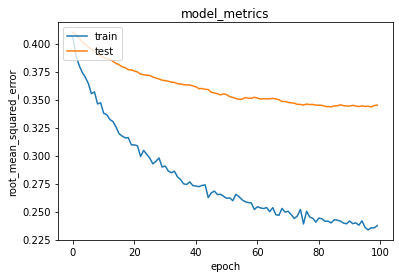

In [56]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Get the Resto Recommendation

In [58]:
resto_df = resto_new
df = pd.read_csv('./data/rating_final.csv')
 
# take sample user
user_id = df.userID.sample(1).iloc[0]
resto_visited_by_user = df[df.userID == user_id]
 
resto_not_visited = resto_df[~resto_df['id'].isin(resto_visited_by_user.placeID.values)]['id'] 
resto_not_visited = list(
    set(resto_not_visited)
    .intersection(set(resto_to_resto_encoded.keys()))
)
 
resto_not_visited = [[resto_to_resto_encoded.get(x)] for x in resto_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_resto_array = np.hstack(
    ([[user_encoder]] * len(resto_not_visited), resto_not_visited)
)

In [60]:
ratings = model.predict(user_resto_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_encoded_to_resto.get(resto_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Resto with high ratings from user')
print('----' * 8)
 
top_resto_user = (
    resto_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .placeID.values
)
 
resto_df_rows = resto_df[resto_df['id'].isin(top_resto_user)]
for row in resto_df_rows.itertuples():
    print(row.resto_name, ':', row.cuisine)
 
print('----' * 8)
print('Top 10 resto recommendation')
print('----' * 8)
 
recommended_resto = resto_df[resto_df['id'].isin(recommended_resto_ids)]

3/3 [==============================] - 0s 4ms/step
Showing recommendations for users: U1046
Resto with high ratings from user
--------------------------------
crudalia : Bar
la Cantina : Bar_Pub_Brewery
Restaurant Wu Zhuo Yi : Chinese
Restaurante Tiberius : Pizzeria
--------------------------------
Top 10 resto recommendation
--------------------------------
